# Описание проекта

Нефтедобывающей компании нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, определяющую регион, где добыча принесёт наибольшую прибыль.

> Этапы выбора локации:
>- в избранном регионе ищут месторождения, для каждого определяют значения признаков;
>- строят модель и оценивают объём запасов;
>- выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от >бюджета компании и стоимости разработки одной скважины;
>- прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:
Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv и geo_data_2.csv.
- id — уникальный идентификатор месторождения;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в месторождении (тыс. баррелей).

Условия задачи:

- Анализируя прибыль и риски использовать технику *Bootstrap*.
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона проводится исследование 500 точек.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- Один баррель сырья приносит 4500 рублей прибыли.
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

---

#### План по выполнению проекта:  
1) Откроем файлы и подготовим данные для обучения и валидации модели.  
2) Обучим модель и проанализируем качество на валидационной выборке.  
3) Подготовим данные и напишим функцию для расчёта прибыли. Найдем распределение прибыли при помощи техники Bootstrap с 1000 выборок.   
4) Расчитаем прибыли и риски убытков.  

---

Импортируем все необходимые для анализа и обучения библиотеки.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy import stats as st

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import figure

import warnings # отключение предупреждений
warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных

Откроем файлы и изучим данные.

In [2]:
data_0 = pd.read_csv('datasets/geo_data_0.csv')
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100000 non-null  int64  
 1   id          100000 non-null  object 
 2   f0          100000 non-null  float64
 3   f1          100000 non-null  float64
 4   f2          100000 non-null  float64
 5   product     100000 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.6+ MB


,Unnamed: 0,id,f0,f1,f2,product
0,0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,2,409Wp,1.022732,0.151990,1.419926,85.265647
3,3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data_1 = pd.read_csv('datasets/geo_data_1.csv')
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100000 non-null  int64  
 1   id          100000 non-null  object 
 2   f0          100000 non-null  float64
 3   f1          100000 non-null  float64
 4   f2          100000 non-null  float64
 5   product     100000 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.6+ MB


,Unnamed: 0,id,f0,f1,f2,product
0,0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
data_2 = pd.read_csv('datasets/geo_data_2.csv')
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100000 non-null  int64  
 1   id          100000 non-null  object 
 2   f0          100000 non-null  float64
 3   f1          100000 non-null  float64
 4   f2          100000 non-null  float64
 5   product     100000 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 4.6+ MB


,Unnamed: 0,id,f0,f1,f2,product
0,0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Для обучения модели первый столбец (`id`) не имеют значения, т.к. это уникальный идентификатор месторождения и этот признак будет только вредить качественному обучению модели. Удалим этот столбец.

In [5]:
data_0 = data_0.drop(['Unnamed: 0','id'], axis=1)
data_1 = data_1.drop(['Unnamed: 0','id'], axis=1)
data_2 = data_2.drop(['Unnamed: 0','id'], axis=1)

Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.

In [6]:
def splitting(data):
    target = data['product']
    features = data.drop(['product'] , axis=1)

    X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

    return target, features, X_train, X_valid, y_train, y_valid

In [7]:
target_0, features_0, X_train0, X_valid0, y_train0, y_valid0 = splitting(data_0)
target_1, features_1, X_train1, X_valid1, y_train1, y_valid1 = splitting(data_1)
target_2, features_2, X_train2, X_valid2, y_train2, y_valid2 = splitting(data_2)

Text(0.5, 1.08, 'Region 2')

<Figure size 432x288 with 0 Axes>

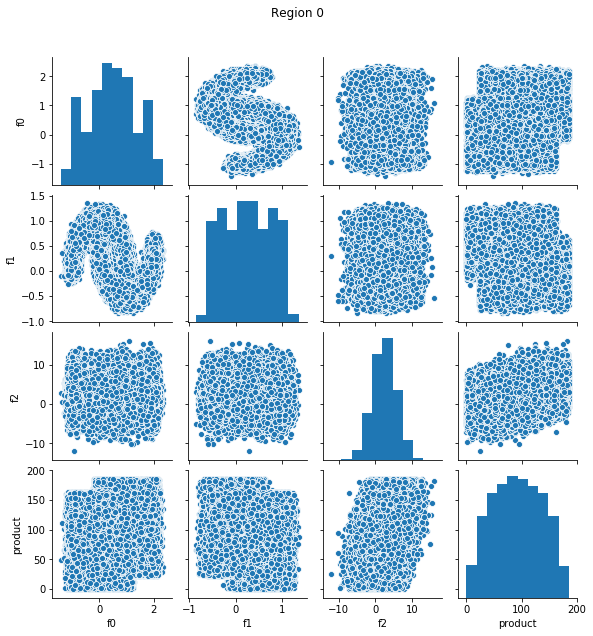

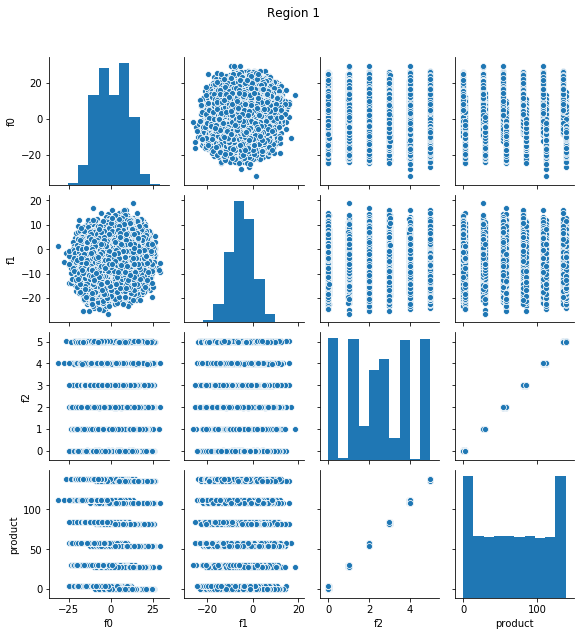

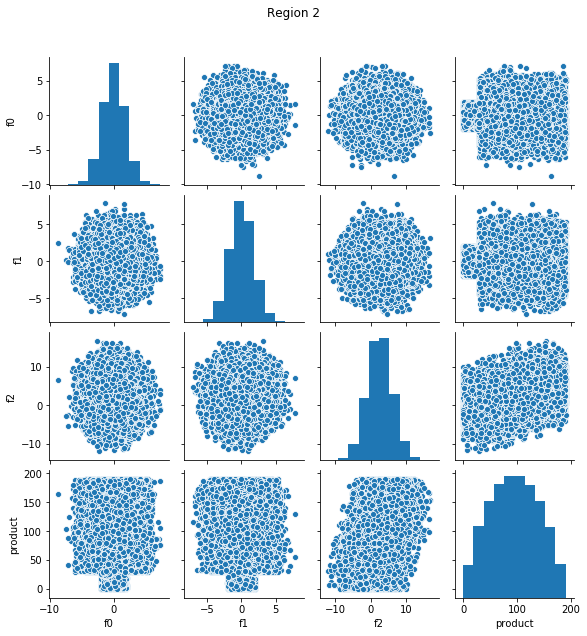

In [8]:
plt.figure()

g0 = sns.pairplot(data=data_0, size=2)
g0.fig.suptitle("Region 0", y=1.08)
g1 = sns.pairplot(data=data_1, size=2)
g1.fig.suptitle("Region 1", y=1.08)
g2 = sns.pairplot(data=data_2, size=2)
g2.fig.suptitle("Region 2", y=1.08)

#### Визуализируем объёмы запасов месторождений по регионам.

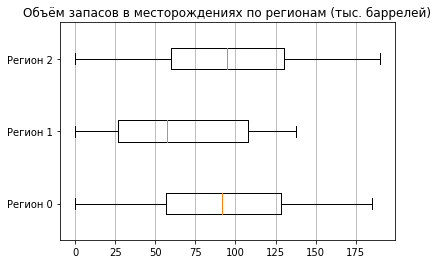

In [9]:
products = [target_0, target_1, target_2]
fig, ax = plt.subplots()

ax.xaxis.grid(True)

ax.set_title('Объём запасов в месторождениях по регионам (тыс. баррелей)')
ax.boxplot(products, vert=False)
ax.set_yticklabels(['Регион 0', 'Регион 1', 'Регион 2'])

plt.show()

По диаграмме видно, что наибольшими запасами обладает "Регион 2". Немного меньшими объёмами обладает "Регион 0". Значительно отстает по запасам "Регион 1".

---

Обучим модель и проверим качество на валидационной выборке.

# 2. Обучение и проверка модели

Для оценки качества модели, помимо метрик `RMSE`, `MAE` и `R2`, для большей наглядности, будем использовать метрику средней абсолютной ошибки в процентах (Mean Absolute Percentage Error - `MAPE`). Так как пока этой метрики нет в библиотеке sklearn, напишем функию для расчета.

In [10]:
def percentage_error(actual, predicted): # среди y_true есть значения равные 0 (деление на 0),
    res = np.empty(actual.shape)         # эта функция для исключения возвращения бесконечности (inf)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape_func(y_true, y_pred): # расчет MAPE 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

Обучим модели для каждого региона, протестируем их предсказания используя кросс-валидацию, определим средний запас сырья месторождений по регионам и выясним качество моделей (используя набор метрик).

При настройке кросс-валидации, количество блоков `cv`зададим не конкретным значением, а будем перетасовывать и разбивать данные при помощи генератора разбиений `ShuffleSplit`.

In [11]:
def lr_test(target, features, X_train, X_valid, y_train, y_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    cv = ShuffleSplit(test_size=0.3, random_state=1)

    scores = cross_val_score(model, features, target, cv=cv)
    final_score = sum(scores) / len(scores)

    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    vol_mean = y_valid.mean()
    r2 = r2_score(y_valid, y_pred)
    mae = mean_absolute_error(y_valid, y_pred)
    mape = mape_func(y_valid, y_pred)  
    return y_pred, final_score, rmse, vol_mean, r2, mae, mape

In [12]:
y_pred0, final_score0, rmse_0, vol_mean0, r2_0, mae_0, mape_0 = lr_test(target_0, features_0, X_train0, X_valid0, y_train0, y_valid0)
y_pred1, final_score1, rmse_1, vol_mean1, r2_1, mae_1, mape_1 = lr_test(target_1, features_1, X_train1, X_valid1, y_train1, y_valid1)
y_pred2, final_score2, rmse_2, vol_mean2, r2_2, mae_2, mape_2 = lr_test(target_2, features_2, X_train2, X_valid2, y_train2, y_valid2)

In [13]:
def metrics(final_score, rmse, vol_mean, r2, mae, mape):
    print('Avg Deposit Volume =', vol_mean)
    print('Avg quality score =', final_score)
    print('\n')
    print('RMSE =', rmse)
    print('MAE  =', mae)
    print("R2   = ", r2)
    print('MAPE = {:.1%}'.format(mape), '\n')

In [14]:
print('- Регион 0 -', '\n')
metrics(final_score0, rmse_0, vol_mean0, r2_0, mae_0, mape_0)
print('- Регион 1 -', '\n')
metrics(final_score1, rmse_1, vol_mean1, r2_1, mae_1, mape_1)
print('- Регион 2 -', '\n')
metrics(final_score2, rmse_2, vol_mean2, r2_2, mae_2, mape_2)

- Регион 0 - 

Avg Deposit Volume = 92.07859674082941
Avg quality score = 0.2767507289722727


RMSE = 37.5794217150813
MAE  = 30.919600777151313
R2   =  0.27994321524487786
MAPE = 212.2% 

- Регион 1 - 

Avg Deposit Volume = 68.72313602437494
Avg quality score = 0.9996245388110816


RMSE = 0.8930992867756173
MAE  = 0.7187662442124751
R2   =  0.9996233978805127
MAPE = 3.0% 

- Регион 2 - 

Avg Deposit Volume = 94.88423280885489
Avg quality score = 0.19809685979710712


RMSE = 40.02970873393434
MAE  = 32.79265210548181
R2   =  0.20524758386040476
MAPE = 321.7% 



In [26]:
def gbr_test(target, features, X_train, X_valid, y_train, y_valid):
    gbr_model = GradientBoostingRegressor()
    gbr_model.fit(X_train, y_train)
    y_pred_gbr = gbr_model.predict(X_valid)

    cv = ShuffleSplit(test_size=0.3, random_state=1)

    scores = cross_val_score(gbr_model, features, target, cv=cv)
    final_score_gbr = sum(scores) / len(scores)

    rmse_gbr = np.sqrt(mean_squared_error(y_valid, y_pred_gbr))
    vol_mean_gbr = y_valid.mean()
    r2_gbr = r2_score(y_valid, y_pred_gbr)
    mae_gbr = mean_absolute_error(y_valid, y_pred_gbr)
    mape_gbr = mape_func(y_valid, y_pred_gbr)  
    return y_pred_gbr, final_score_gbr, rmse_gbr, vol_mean_gbr, r2_gbr, mae_gbr, mape_gbr

In [27]:
y_pred0, final_score0, rmse_0, vol_mean0, r2_0, mae_0, mape_0 = gbr_test(target_0, features_0, X_train0, X_valid0, y_train0, y_valid0)
y_pred1, final_score1, rmse_1, vol_mean1, r2_1, mae_1, mape_1 = gbr_test(target_1, features_1, X_train1, X_valid1, y_train1, y_valid1)
y_pred2, final_score2, rmse_2, vol_mean2, r2_2, mae_2, mape_2 = gbr_test(target_2, features_2, X_train2, X_valid2, y_train2, y_valid2)

In [28]:
print('- Регион 0 -', '\n')
metrics(final_score0, rmse_0, vol_mean0, r2_0, mae_0, mape_0)
print('- Регион 1 -', '\n')
metrics(final_score1, rmse_1, vol_mean1, r2_1, mae_1, mape_1)
print('- Регион 2 -', '\n')
metrics(final_score2, rmse_2, vol_mean2, r2_2, mae_2, mape_2)

- Регион 0 - 

Avg Deposit Volume = 92.07859674082941
Avg quality score = 0.29680673224644216


RMSE = 37.0652094907526
MAE  = 30.522327240495052
R2   =  0.2995139682070832
MAPE = 198.9% 

- Регион 1 - 

Avg Deposit Volume = 68.72313602437494
Avg quality score = 0.9997563444099521


RMSE = 0.7302021847058401
MAE  = 0.37552169243889827
R2   =  0.999748249970127
MAPE = 1.3% 

- Регион 2 - 

Avg Deposit Volume = 94.88423280885489
Avg quality score = 0.287597107964853


RMSE = 37.7305943319905
MAE  = 31.149970524743996
R2   =  0.293919383587415
MAPE = 279.5% 



In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Number of trees used in the boosting process
n_estimators = [50, 100, 150]

# Maximum depth of each tree
max_depth = [2, 3, 5, 8]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4]

# Minimum number of samples to split a node
min_samples_split = [2, 4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {#'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split}
#     'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=5, 
#     scoring = 'neg_mean_absolute_error',
#     n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

# Fit on the training data
random_cv.fit(X_train0, y_train0) 
# # # Find the best combination of settings
# random_cv.best_estimator_
# GradientBoostingRegressor(loss='lad', max_depth=5,
#     max_features=None,
#     min_samples_leaf=6,
#     min_samples_split=6,
#     n_estimators=500)

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [24]:
print(random_cv.best_estimator_.get_params()['n_estimators'])

100


Величина среднего объёма запасов месторождений больше всего в "Регион 2" (94.9т.баррелей) и "Регион 0" (92.1т.баррелей), но в этих регионах наша модель плохо предсказывает результаты. 

Все метрики говорят о плохом качестве моделей.  
Наихудший в обучении "Регион 2" - оценка качества модели меньше 0.2. В среднем, разница между действительными наблюдениями и значениями, предсказанными моделью (RMSE) - 40, средняя абсолютная ошибка (MAE) - 32.79, коэффициент детерминации (R2) всего 0.2, ошибка прогноза (MAPE) - 321%!  
Кардинально иные результаты обучения показал "Регион 1". Оценка точности - 0.999, (RMSE) < 1, средняя абсолютная ошибка (MAE) < 1, коэффициент детерминации (R2) почти единица, ошибка прогноза (MAPE) всего 3%.


Визуализируем качество моделей на гистограмме.

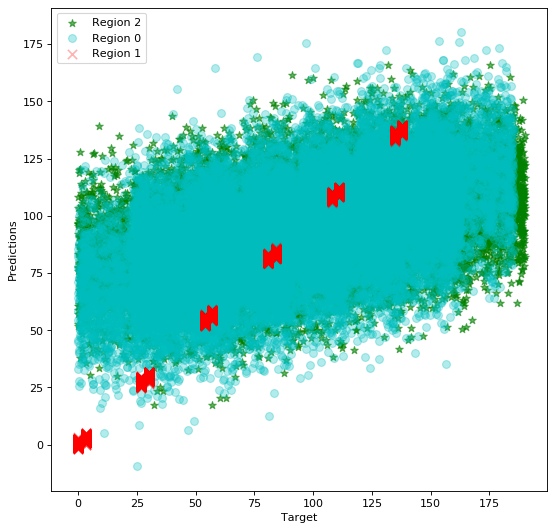

In [14]:
plt.figure(figsize=(8, 8), dpi=80)

plt.scatter(y_valid2, y_pred2, marker='*', 
            color='g',
            alpha=0.6,
            s = 50,
            label='Region 2')

plt.scatter(y_valid0, y_pred0, marker='o', 
            color='c',
            alpha=0.3,
            s = 50,
            label='Region 0')

plt.scatter(y_valid1, y_pred1, marker='x', 
            color='r',
            alpha=0.3,
            s = 70,
            label='Region 1')

plt.ylabel('Predictions')
plt.xlabel('Target')

plt.legend(loc='upper left')

Видно, что доверять предсказаниям можно только модели в "Регион 1".

# 3. Подготовка к расчёту прибыли

Создадим переменные, указанные в условии задачи. 

Напишем функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели.

In [15]:
BDG = 10000000000 # budget
COD = 50000000 # cost of drilling a well
PPB = 4500 # profit per barrel

well_total = int(BDG / COD)

vol_res = BDG / PPB / well_total / 1000 # minimum av.reserve of a well for 0 profit in thousands BBL

print('Общее количество скважен исходя из бюджета =', well_total)
print('Мин. средний объём сырья в месторождении региона, достаточный для его разработки из расчета общего бюджета: {:.1f} тыс. баррелей.'.format(vol_res))

Общее количество скважен исходя из бюджета = 200
Мин. средний объём сырья в месторождении региона, достаточный для его разработки из расчета общего бюджета: 11.1 тыс. баррелей.


In [16]:
y_pred0 = pd.Series(y_pred0) # преобразуем тип в pd.Series
y_pred1 = pd.Series(y_pred1)
y_pred2 = pd.Series(y_pred2)

y_valid0 = y_valid0.reset_index(drop=True) # переиндексация строк 
y_valid1 = y_valid1.reset_index(drop=True)
y_valid2 = y_valid2.reset_index(drop=True)

In [17]:
def profit(y, y_prob, count):
    probs_sorted = y_prob.sort_values(ascending=False)
    selected = y[probs_sorted.index][:count]
    return PPB * selected.sum() * 1000 - BDG # точка окупаемости региона (прибыль-капитальные вложения/инвестиции на разработку)

In [18]:
state = np.random.RandomState(12345) # генератор случайных чисел
def avgpr_ci(y, y_prob):    
    values = []
    for i in range(1000):
        target_subsample = y.sample(n=500, replace=True, random_state=state)
        prob_subsample = y_prob[target_subsample.index]
        values.append(profit(target_subsample, prob_subsample, well_total))
    
    values = pd.Series(values)
    prof_avg = values.mean()  
    y_avg = y.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, prof_avg, values.sem())
    #Комментарий наставника: смотри, ты учитываешь риск убытка только на одной (последней) итерации Bootstrap, а нужно учитывать
    #их все, как я писал ниже. Во—вторых, нужные нам данные — это «values». Часть из них может быть
    #отрицательна, что символизирует убыток. На основании этого и считается риск убытка для региона.
    loss_risk = st.percentileofscore(values, 0) # на основании данных (прибыль 200 месторождений региона после
                                                # возврата инвестиций) Bootstrap 
    return prof_avg, y_avg, confidence_interval, loss_risk    

In [19]:
def results(prof_avg, y_avg, confidence_interval, loss_risk):
    print("Среднее значение прибыли: {:.2f}".format(prof_avg), "руб.")
    print("95%-ый доверительный интервал:", confidence_interval, '\n')
    print("Средний объём сырья в месторождении региона:", y_avg, '\n')
    
    print('Риск убытков региона 0 =', loss_risk, '\n'*2)

# 4. Расчёт прибыли и рисков 

In [20]:
prof_avg0, y_avg0, confidence_interval0, loss_risk0 = avgpr_ci(y_valid0, y_pred0)
prof_avg1, y_avg1, confidence_interval1, loss_risk1 = avgpr_ci(y_valid1, y_pred1)
prof_avg2, y_avg2, confidence_interval2, loss_risk2 = avgpr_ci(y_valid2, y_pred2)

In [21]:
print('- Регион 0 -', '\n')
results(prof_avg0, y_avg0, confidence_interval0, loss_risk0)

print('- Регион 1 -', '\n')
results(prof_avg1, y_avg1, confidence_interval1, loss_risk1)

print('- Регион 2 -', '\n')
results(prof_avg2, y_avg2, confidence_interval2, loss_risk2)

- Регион 0 - 

Среднее значение прибыли: 94257228605.86 руб.
95%-ый доверительный интервал: (94084990292.21442, 94429466919.49835) 

Средний объём сырья в месторождении региона: 92.07859674082941 

Риск убытков региона 0 = 0.0 


- Регион 1 - 

Среднее значение прибыли: 95182637854.86 руб.
95%-ый доверительный интервал: (95052540096.80276, 95312735612.9137) 

Средний объём сырья в месторождении региона: 68.72313602437494 

Риск убытков региона 0 = 0.0 


- Регион 2 - 

Среднее значение прибыли: 94202076170.96 руб.
95%-ый доверительный интервал: (94025594400.78354, 94378557941.133) 

Средний объём сырья в месторождении региона: 94.88423280885489 

Риск убытков региона 0 = 0.0 




Во всех регионах инвестиции/затраты на капитальные вложения (бурение скважин) окупятся и рентабельность инвестируемого капитала ROIC (Return On Invested Capital) во всех случаях более 940%. 95% доверительный интервал подтверждает, что все регионы (с запасом) являются прибыльными.

При расчете возможных рисков, мы не смогли обнаружить убыточные регионы по предсказаниям модели (т.е. те регионы, прибыль которых после возврата капитальных вложений/инвестиций меньше нуля). Все регионы имеют нулевые риски.  

---

## Вывод:

Хотя модель плохо делает предсказания (в 2-х случаях из 3-х), по результатам нашего исследования наилучшим регионом для разработки 200 месторождений представляется "*Регион 1*". Этот регион не с самым высоким значением среднего объема запасов, однако, по нашим прогнозам "*Регион 1*" самый прибыльный.

#### Добыча принесёт наибольшую прибыль в "Регион 1".
